In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import derivative
from datetime import datetime
import time

from datetime import datetime
import pandas as pd




from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from datetime import datetime

import tensorflow as tf
from tensorflow import keras

## Load The Data:

In [2]:
#Joe Stroud
import pandas as pd

#Importing Cassini data with labels
df = pd.read_csv('2004_FGM_KSM_1M.TAB', delimiter = '\\s+', names = ['Time', 'Bx', 'By', 'Bz', 'BTotal', 'X', 'Y', 'Z', 'Local Hour', 'NPTS'])

In [ ]:
df

,Time,Bx,By,Bz,BTotal,X,Y,Z,Local Hour,NPTS
0,2004-05-11T00:00:30,0.061,0.142,-0.041,0.161,172.297,-404.888,-57.532,7.2,-1
1,2004-05-11T00:01:30,0.065,0.149,-0.039,0.169,172.295,-404.884,-57.524,7.2,-1
2,2004-05-11T00:02:30,0.072,0.137,-0.040,0.161,172.293,-404.880,-57.516,7.2,-1
3,2004-05-11T00:03:30,0.078,0.138,-0.036,0.163,172.291,-404.876,-57.509,7.2,-1
4,2004-05-11T00:04:30,0.071,0.143,-0.034,0.164,172.288,-404.872,-57.501,7.2,-1
...,...,...,...,...,...,...,...,...,...,...
312254,2004-12-31T23:55:30,-0.111,-0.390,-0.191,0.449,19.435,-56.256,3.744,7.3,60
312255,2004-12-31T23:56:30,-0.116,-0.391,-0.204,0.457,19.436,-56.255,3.744,7.3,60
312256,2004-12-31T23:57:30,-0.138,-0.379,-0.209,0.455,19.437,-56.255,3.745,7.3,60
312257,2004-12-31T23:58:30,-0.134,-0.376,-0.200,0.447,19.438,-56.254,3.745,7.3,60


In [3]:
#Joe Stroud
#assigning variables
time = df['Time']
Bx = df['Bx']
By = df['By']
Bz = df['Bz']
BTotal = df['BTotal']
X = df['X']
Y = df['Y']
Z = df['Z']
Local_hour = df['Local Hour']
NPTS = df['NPTS']

## Plot Crossings for Training and Determine Threshold:

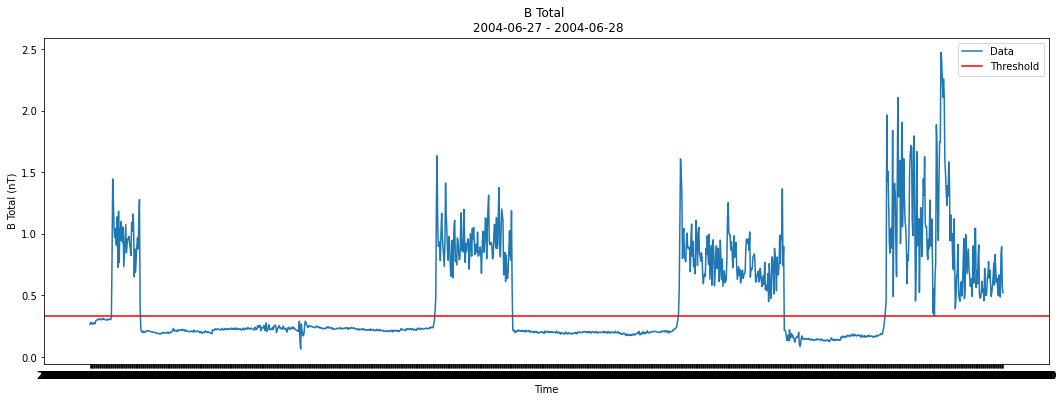

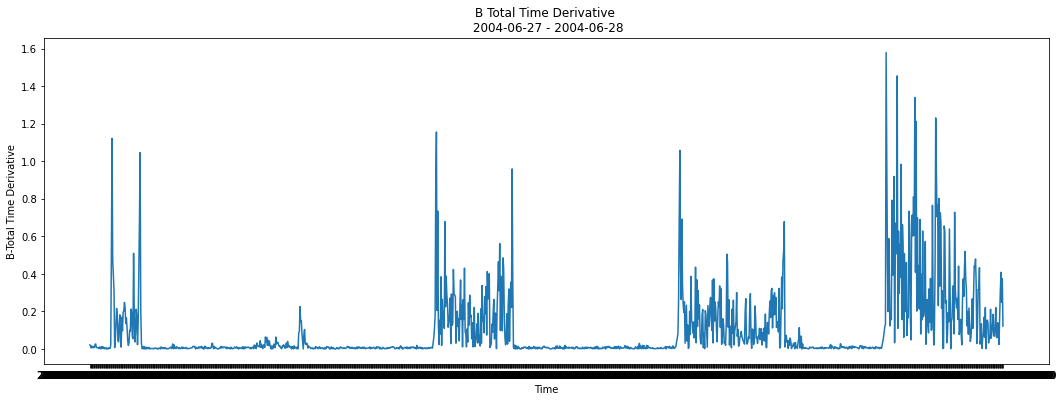

In [ ]:
#1st set of crossings shown in N. Achilleos Paper:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], BTotal[63600:65000], label="Data")

plt.axhline(y = 0.33, color = 'red', label="Threshold") #show best threshold

plt.title('B Total \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()



#plot the time derivative to see if threshold is easier to observe:
signal_grad = abs(np.gradient(BTotal[63600:65000],0.5))

plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], signal_grad)
plt.title('B Total Time Derivative \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B-Total Time Derivative')
plt.show()

Thee threshold is the B-value that, above which, Cassini is in the bow-shock and below which it is in the solar wind. Whether Cassini is in the BS or SW for this data range is shown in the N. Achilleos paper. Here, a threshold of 0.33 for the unormalised data was chosen.

The derivative data is not conducive to an accurate selection of thresholds. This is because the derivatives when in the bow-shock are close to the solar-wind derivatives. Therefore, the appropriate threshold is difficult to identify.

## Normalise Data:

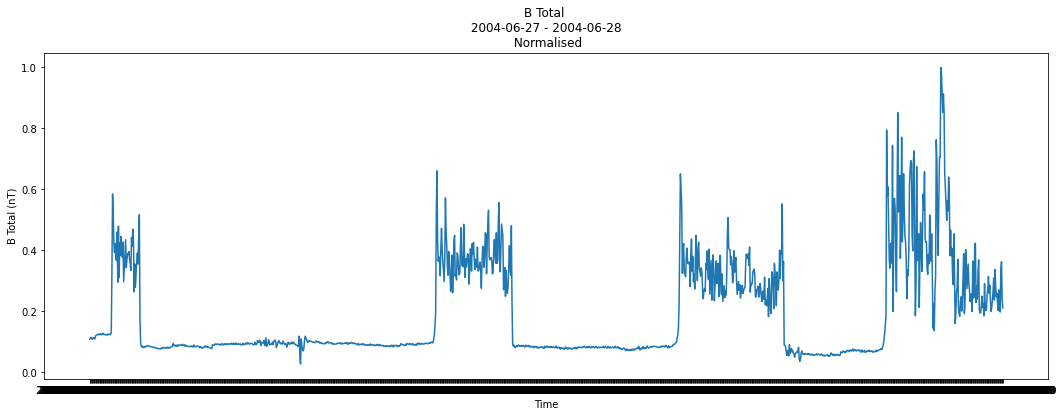

In [4]:
def norm(data):
  ''''Normalised data
  Input: data
  Output: normalised data
  '''
  return data/np.amax(data) #divide by max value

#plot the normalised data:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], norm(BTotal[63600:65000]))
plt.title('B Total \n 2004-06-27 - 2004-06-28 \n Normalised')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')
plt.show()

## Label-Obtaining Function Using the Threshold:

In [5]:
#labels via constant threshold method:
def label(b, th):
  '''Labels for the NN (the values, for the data, the NN has to get to)
  Inputs: b (magnetic field values), th (threshold)
  Outputs: labels (either 0 or 1) at different points in orbit
  '''

  #normalised labels:
  labels = np.array(b)/np.amax(b)

  np.place(labels, labels>=th, 1) #anything above th, label as 1 (bow shock) 
  np.place(labels, labels<th, 0) #anything below th, label as 0 (solar wind)

  return labels

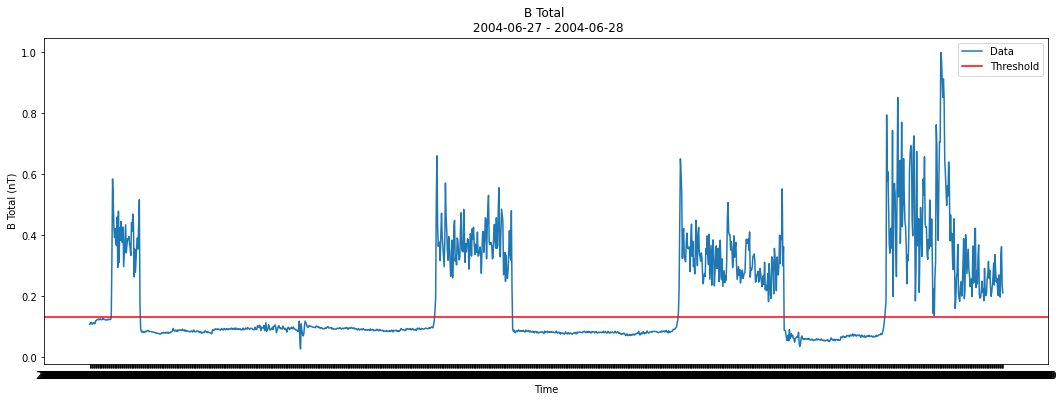

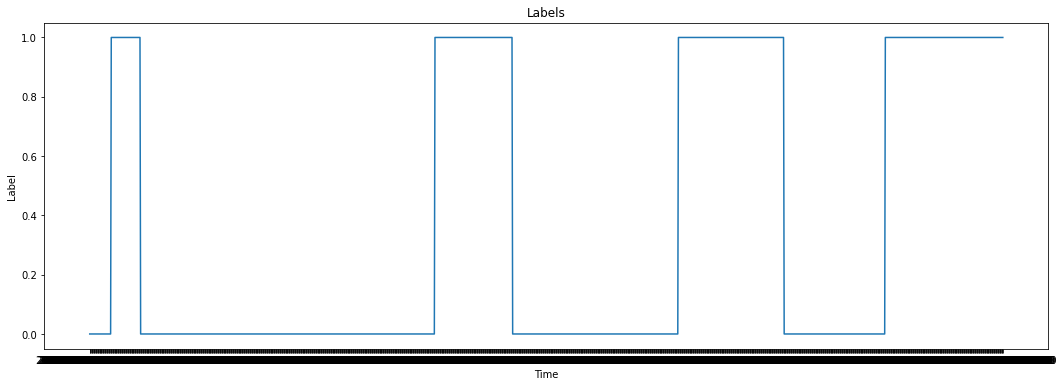

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], norm(BTotal[63600:65000]), label="Data")

plt.axhline(y = 0.13, color = 'red', label="Threshold") #threshold for normalised data

plt.title('B Total \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()


#plot label:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], label(norm(BTotal[63600:65000]), 0.13))
plt.title('Labels')
plt.xlabel('Time')
plt.ylabel('Label')
plt.show()

## Smooth Data for Easy NN Input

Even though, a noise training set will improve the accuracy of a neural network, we are using a threshold method to determine the level, above which, Cassini is in the bow-shock. A smooth dataset will make it easier to determine the threshold since the bow-shock and solar wind data is more clear. See the above dataset vs the smooth dataset below. 



In [6]:
def smooth(y, box_pts):
  '''Smoothed data
  Inputs: y (data), box_pts
  Output: smoothed data
  '''
  box = np.ones(box_pts)/box_pts
  y_smooth = np.convolve(y, box, mode='same')
  return y_smooth

smoothed_signal1 = smooth(BTotal[63600:65000],25)

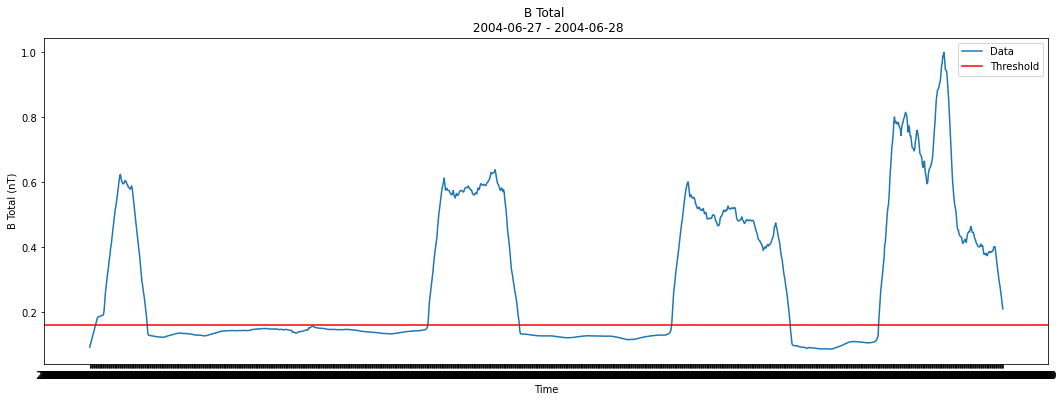

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(time[63600:65000], norm(smoothed_signal1), label="Data")

plt.axhline(y = 0.16, color = 'red', label="Threshold") #threshold for normalised data

plt.title('B Total \n 2004-06-27 - 2004-06-28')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()

## Neural Network:

In [7]:
X = pd.Series(norm(smoothed_signal1)) #data
y = label(X, 0.16) #labels


#obtain test and training data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True)

In [12]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32, input_shape=(None,1,1), activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, None, 1, 32)       64        
                                                                 
 dense_7 (Dense)             (None, None, 1, 64)       2112      
                                                                 
 dense_8 (Dense)             (None, None, 1, 1)        65        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=200, epochs=50, validation_data=(X_test,y_test))

Epoch 1/50
5/5 [==============================] - 1s 59ms/step - loss: 0.6853 - accuracy: 0.7184 - val_loss: 0.6782 - val_accuracy: 0.9833
Epoch 2/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6745 - accuracy: 0.9837 - val_loss: 0.6672 - val_accuracy: 0.9762
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6637 - accuracy: 0.9786 - val_loss: 0.6560 - val_accuracy: 0.9690
Epoch 4/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6526 - accuracy: 0.9786 - val_loss: 0.6444 - val_accuracy: 0.9690
Epoch 5/50
5/5 [==============================] - 0s 11ms/step - loss: 0.6413 - accuracy: 0.9765 - val_loss: 0.6324 - val_accuracy: 0.9667
Epoch 6/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6293 - accuracy: 0.9735 - val_loss: 0.6196 - val_accuracy: 0.9667
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 0.6165 - accuracy: 0.9714 - val_loss: 0.6064 - val_accuracy: 0.9643
Epoch 8/50
5/5 [===========

## Loss and Accuracy Graphs Over The Epochs:

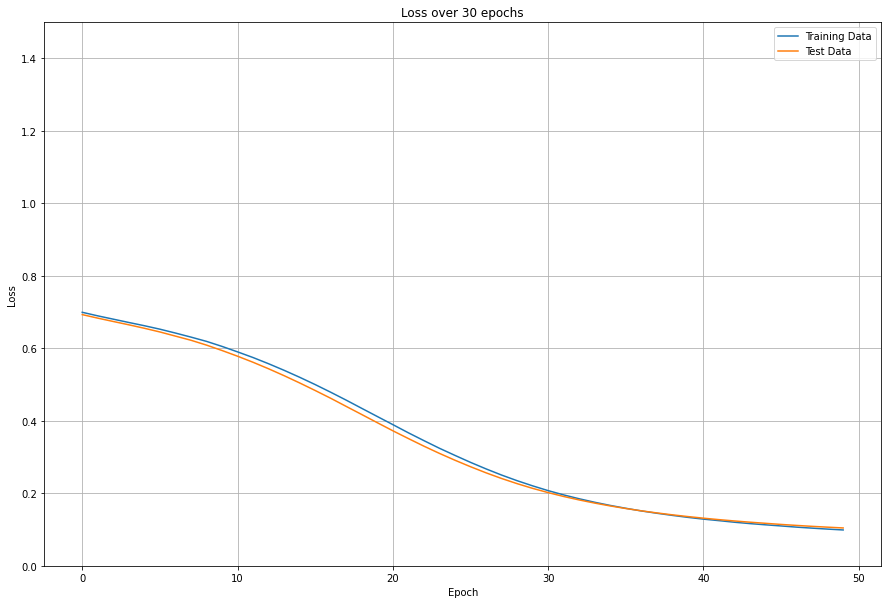

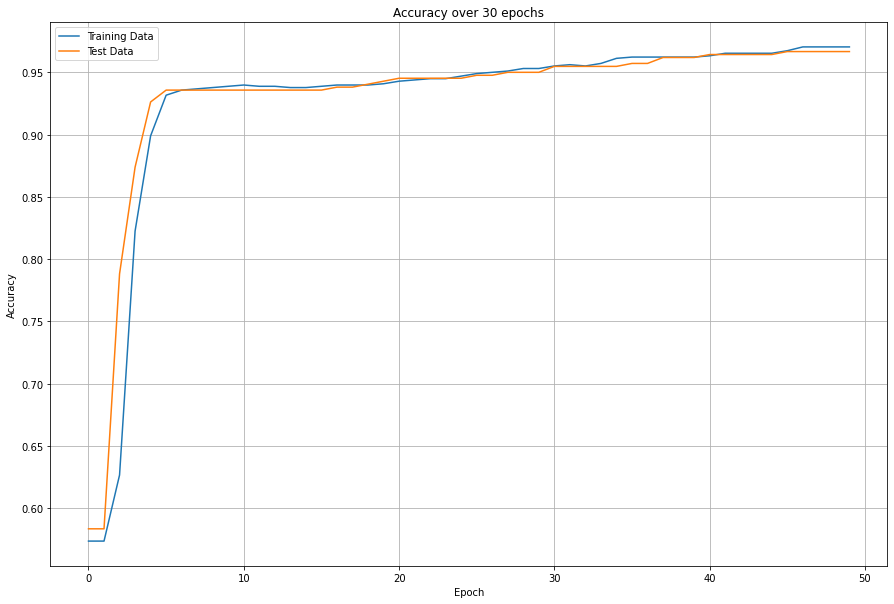

In [14]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'], label = "Training Data") #training loss
plt.plot(history.history['val_loss'], label = "Test Data") #test loss
plt.xlabel("Epoch")
plt.grid(True, which="both")
plt.title("Loss over 30 epochs")
plt.ylim(0,1.5)
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'], label = "Training Data") #training loss
plt.plot(history.history['val_accuracy'], label = "Test Data") #test loss
plt.legend()
plt.grid(True, which="both")
plt.title("Accuracy over 30 epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Test With Unseen Data:

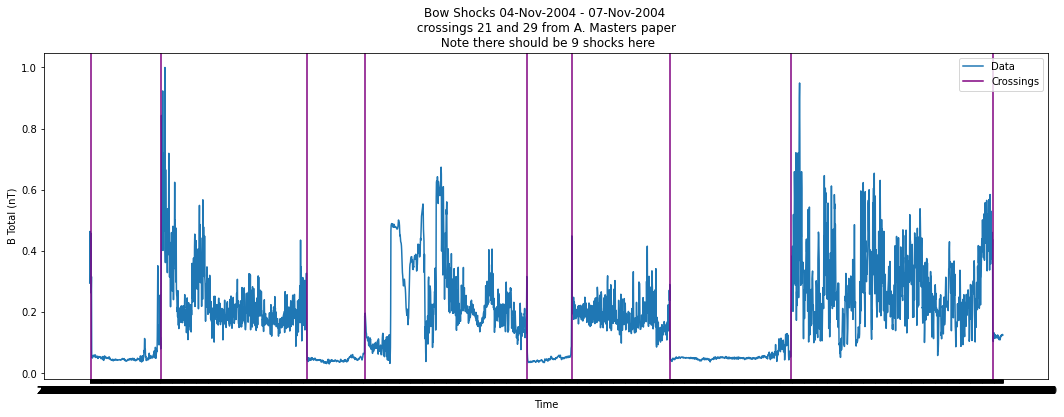

In [ ]:
data = BTotal[65014:65016] #all 2004 November crossings


#use all 2004 November crossings data from A. Masters paper:
plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], norm(BTotal[232420:236150]), label="Data")

#indicate crossings using vertical lines at crossings time (given in A. Masters paper):
plt.axvline(x='2004-11-04T22:41:30', color='purple', label="Crossings")
plt.axvline(x='2004-11-05T03:34:30', color='purple')
plt.axvline(x='2004-11-05T13:36:30', color='purple')
plt.axvline(x='2004-11-05T17:33:30', color='purple')
plt.axvline(x='2004-11-06T04:41:30', color='purple')
plt.axvline(x='2004-11-06T07:44:30', color='purple')
plt.axvline(x='2004-11-06T14:36:30', color='purple')
plt.axvline(x='2004-11-06T23:01:30', color='purple')
plt.axvline(x='2004-11-07T12:43:30', color='purple')

#plt.axhline(y = 0.11, color = 'red')

plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 \n crossings 21 and 29 from A. Masters paper \n Note there should be 9 shocks here')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()

The appropriate threshold is difficult to observe since the data is too noisy. Thus, smooth the data with the smoothing function:

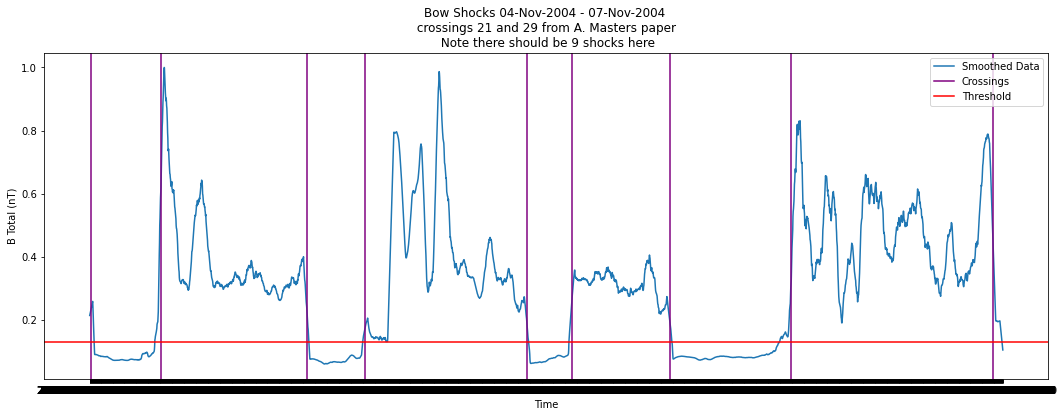

In [ ]:
from astropy.convolution import convolve, Box1DKernel

smoothed_signal2 = smooth(BTotal[232420:236150],25)

plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], norm(smoothed_signal2), label="Smoothed Data")

#indicate crossings using vertical lines at crossings time (given in A. Masters paper):
plt.axvline(x='2004-11-04T22:41:30', color='purple', label= "Crossings")
plt.axvline(x='2004-11-05T03:34:30', color='purple')
plt.axvline(x='2004-11-05T13:36:30', color='purple')
plt.axvline(x='2004-11-05T17:33:30', color='purple')
plt.axvline(x='2004-11-06T04:41:30', color='purple')
plt.axvline(x='2004-11-06T07:44:30', color='purple')
plt.axvline(x='2004-11-06T14:36:30', color='purple')
plt.axvline(x='2004-11-06T23:01:30', color='purple')
plt.axvline(x='2004-11-07T12:43:30', color='purple')

plt.axhline(y = 0.13, color = 'red', label="Threshold") #chosen threshold

plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 \n crossings 21 and 29 from A. Masters paper \n Note there should be 9 shocks here')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()

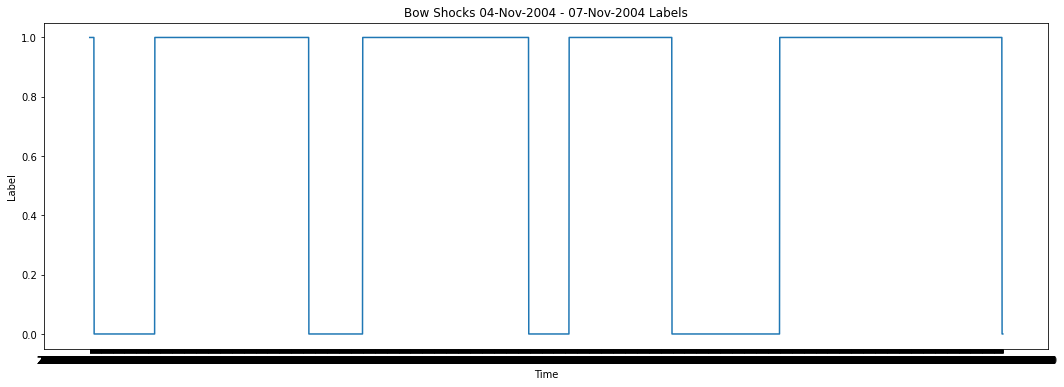

In [ ]:
y2 = label(norm(smoothed_signal2), 0.13) #labels using 0.13 threshold

#plot lablels:
plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], y2)

plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels')
plt.xlabel('Time')
plt.ylabel('Label')
plt.show()

### Plot an ROC curve to visualise accuracy of NN:

There are 681 number of thresholds (i.e number of points) used to plot the ROC-curve.


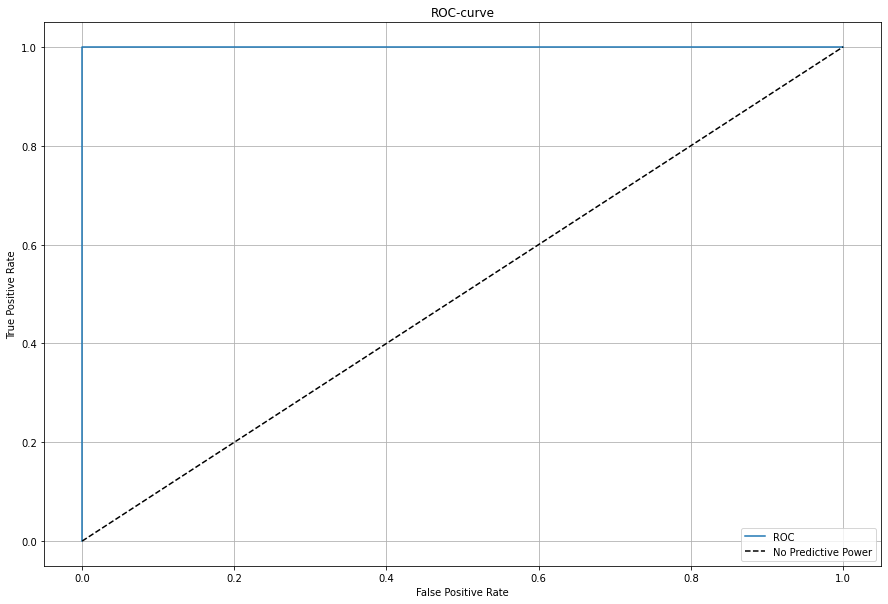

The area under the ROC-curve is = 1.0


In [15]:
X2 = pd.Series(norm(smoothed_signal2)) #data
y2 = label(norm(smoothed_signal2), 0.13) #labels

prediction = model.predict(X2) #the test prediction required to assess performance
fpr, tpr, threshold = roc_curve(y2, prediction) #labels and prediction is required to calculate TPR and FPR
print("There are", len(threshold), "number of thresholds (i.e number of points) used to plot the ROC-curve.")


plt.figure(figsize=(15,10))
plt.plot(fpr,tpr, label='ROC')
#plt.plot([0,0],[0,1], color='green', label='Perfect Predictive Power') #plot for perfect NN comparison
#plt.plot([0,1],[1,1], color='green')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.legend()
plt.grid(True, which="both")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve")
plt.show()

#auc:
roc_auc = roc_auc_score(y2, prediction) #requires labels and predictions (which are probabilities)
print("The area under the ROC-curve is =", roc_auc) 

### Compare predictions from NN with labels:

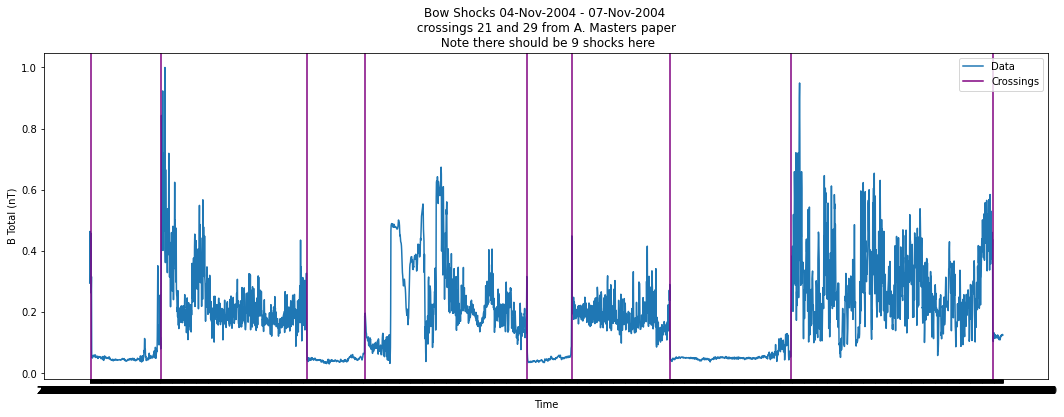

In [ ]:
#plot data for comparison with prediction and labels:
plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], norm(BTotal[232420:236150]), label="Data")

plt.axvline(x='2004-11-04T22:41:30', color='purple', label="Crossings")
plt.axvline(x='2004-11-05T03:34:30', color='purple')
plt.axvline(x='2004-11-05T13:36:30', color='purple')
plt.axvline(x='2004-11-05T17:33:30', color='purple')
plt.axvline(x='2004-11-06T04:41:30', color='purple')
plt.axvline(x='2004-11-06T07:44:30', color='purple')
plt.axvline(x='2004-11-06T14:36:30', color='purple')
plt.axvline(x='2004-11-06T23:01:30', color='purple')
plt.axvline(x='2004-11-07T12:43:30', color='purple')

#plt.axhline(y = 0.11, color = 'red')

plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 \n crossings 21 and 29 from A. Masters paper \n Note there should be 9 shocks here')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.legend()
plt.show()

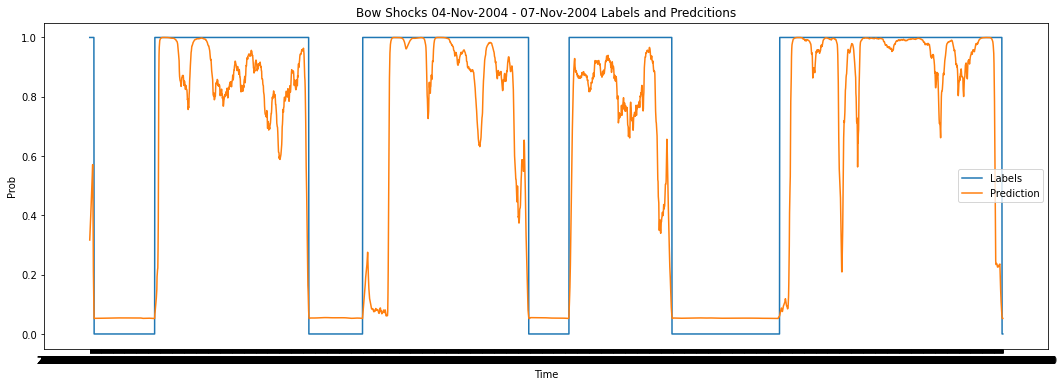

In [19]:
#prediction vs label:

plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], y2, label="Labels")
plt.plot(time[232420:236150], prediction, label="Prediction") #prediction raw
plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels and Predcitions')
plt.xlabel('Time')
plt.ylabel('Prob')
plt.legend()
plt.show()

The above prediction plot is a probability distribution where each point decribes the probability that correspoding B-Total value is closer to 0 (Solar Wind) or 1 (Bow-Shock). This is why even though while in the BS, the prediction is not close to 1 because, in the bow-shock, B-Total is not constant and very noisy. 

However, this issue is trivial since we are only concerned with identifying the crossings. Thus we have to smooth the predictions and round to the nearest integer to match the labels. Then calculate the gradient which will leave only the crossings:

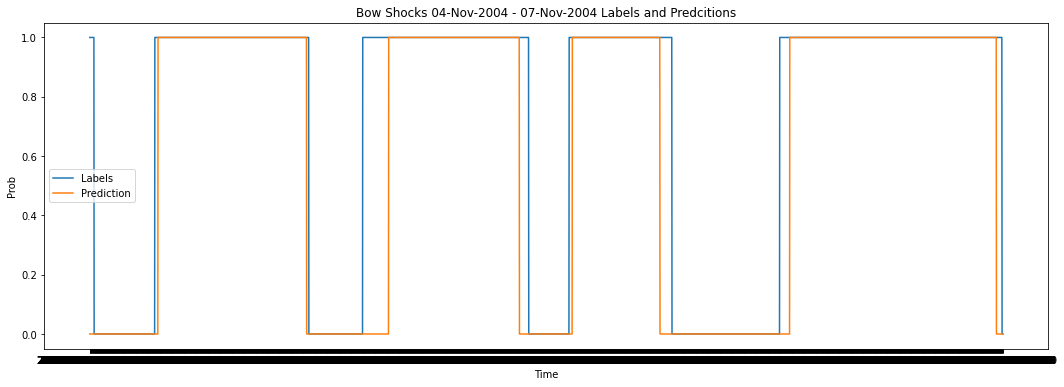

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], y2, label="Labels")
plt.plot(time[232420:236150], np.rint(smooth(np.ndarray.flatten(prediction),50)), label="Prediction") #smooth data and round
plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels and Predcitions')
plt.xlabel('Time')
plt.ylabel('Prob')
plt.legend()
plt.show()

The croosings match up with the labels. Now plot the gradient. The gradient at the crossings will be high (since its a veritcal line) and otherwise will be 0 (since its flat elsewhere). Thus, leaving only the crossings:

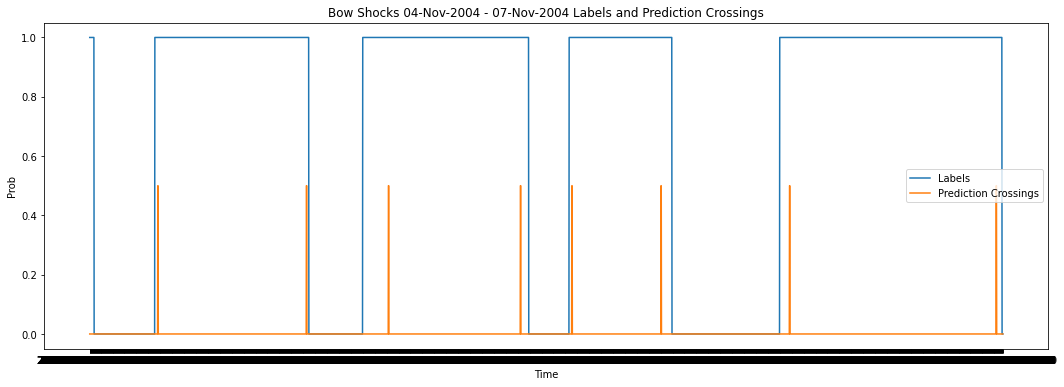

In [17]:
pred_int_grad = abs(np.gradient(np.rint(smooth(np.ndarray.flatten(prediction),50)))) #crossings from prediction

plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], y2, label="Labels")
plt.plot(time[232420:236150], pred_int_grad, label="Prediction Crossings")
plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 Labels and Prediction Crossings')
plt.xlabel('Time')
plt.ylabel('Prob')
plt.legend()
plt.show()

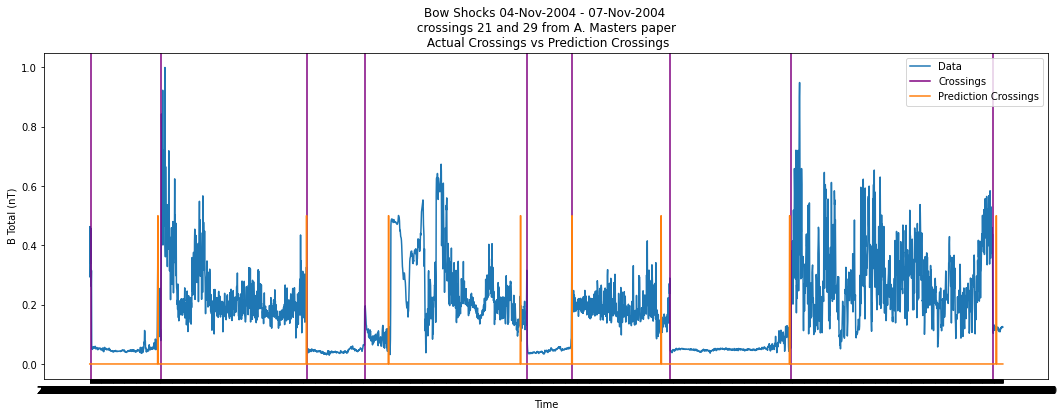

In [18]:
#plot comparison between prediction crossings and actual crossings:


plt.figure(figsize=(18, 6))
plt.plot(time[232420:236150], norm(BTotal[232420:236150]), label="Data")

plt.axvline(x='2004-11-04T22:41:30', color='purple', label="Crossings")
plt.axvline(x='2004-11-05T03:34:30', color='purple')
plt.axvline(x='2004-11-05T13:36:30', color='purple')
plt.axvline(x='2004-11-05T17:33:30', color='purple')
plt.axvline(x='2004-11-06T04:41:30', color='purple')
plt.axvline(x='2004-11-06T07:44:30', color='purple')
plt.axvline(x='2004-11-06T14:36:30', color='purple')
plt.axvline(x='2004-11-06T23:01:30', color='purple')
plt.axvline(x='2004-11-07T12:43:30', color='purple')

#plt.axhline(y = 0.11, color = 'red')

plt.title('Bow Shocks 04-Nov-2004 - 07-Nov-2004 \n crossings 21 and 29 from A. Masters paper \n Actual Crossings vs Prediction Crossings')
plt.xlabel('Time')
plt.ylabel('B Total (nT)')

plt.plot(time[232420:236150], pred_int_grad, label="Prediction Crossings")

plt.legend()
plt.show()

## Function to Obtain Crossings for Any Data Once NN is Trained:

In [19]:
def crossings(b, box_pts1, box_pts2):
  '''Bow-Shock Crossings

  Inputs: b (B-Total data), box_pts1 (smoothing-level of data), 
  boxpts2 (smoothing-level of prediction)
  
  Output: pred_int_grad (an arrray of 0s and 0.5s where the 0.5s are 
  the points of bow-shock crossings)'''
  
  #smooth data:
  box = np.ones(box_pts)/box_pts
  smoothed_data = np.convolve(b, box, mode='same')

  #normalise smoothed data:
  norm_smth = smoothed_data/np.amax(smoothed_data)

  #prediction:
  X = pd.Series(norm(smoothed_data)) #data
  prediction = model.predict(X)

  #smooth and "straighten" predictions:
  box2 = np.ones(box_pts2)/box_pts2
  pred_smth =  np.convolve(np.ndarray.flatten(prediction), box2, mode='same')
  straight = np.rint(pred_smth)

  #calculate grad to isolate crossings:
  pred_int_grad = abs(np.gradient(straight))

  return pred_int_grad